## Imports

In [1]:
from torch import nn
import torch
import platform
from typing import Callable, List, Optional, Dict
import numpy as np
import scipy.sparse as sp

print(torch.__version__)
print(torch.version.cuda)
print(platform.python_version())

from torch_geometric.data import (
    HeteroData,
    Data,
    InMemoryDataset,
    Batch
    )
from torch_geometric.data.storage import EdgeStorage
import torch_geometric.datasets as datasets
import torch_geometric.transforms as transforms
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

1.10.1+cu102
10.2
3.6.9


## Dataset creation

### Graph file locations

In [2]:
files = ["/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Samples/example1_graph_dump.txt", 
         "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Samples/example2_graph_dump.txt"]

### Method to process raw graph data(in .txt format)

In [3]:
def get_nodes_edges(inTextFile):
  # FD = 0, CD = 1
  # to support the hetero data object as suggested by the documentation 
  nodes_dict = {}
  edge_indices_CD = []
  edge_indices_FD = []

  #to support the Data object as used by the Entities dat object as used in RGAT source code
  edge_indices = []
  edge_type = []
  
  
  # nodes_dict is an index_map
  node_count=0
  with open(inTextFile) as fp:

    Lines = fp.readlines()
    for line in Lines:

      N = line.split('-->')
        
      t1 = N[0].split('$$')   
      src = t1[1].strip()   
      if src not in nodes_dict.keys():
        nodes_dict[src] = node_count
        node_count+=1
        
      t2 = N[1].split('$$')
      idx = t2[1].rfind('[')
      dst = t2[1][:idx].strip()
      if dst not in nodes_dict.keys():
        nodes_dict[dst] = node_count
        node_count+=1

      x = t2[1].strip()[idx + 1:-1].strip()
      if(x == 'FD'):
        y=0
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        edge_indices_FD.append([nodes_dict[src], nodes_dict[dst]])
      else: 
        y=1
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        edge_indices_CD.append([nodes_dict[src], nodes_dict[dst]])
     
  return nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type

### Method to get CodeBERT embedding for nodes

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")

In [14]:
def get_node_embedding_from_codebert(nodes):
    list_of_embeddings = []
    for code_line in nodes.keys():
        code_tokens=tokenizer.tokenize(code_line)
        tokens=[tokenizer.cls_token]+code_tokens+[tokenizer.eos_token]
        tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
        context_embeddings=model(torch.tensor(tokens_ids)[None,:])
        cls_token_embedding = context_embeddings.last_hidden_state[0,0,:]
        list_of_embeddings.append(cls_token_embedding)
    return torch.stack(list_of_embeddings)

### Method to create data objects for GNN

In [17]:
# Data
d_list =[]
for i, file in enumerate(files):
  nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type = get_nodes_edges(file)
  #print(nodes_dict, edge_indices_CD, edge_indices_FD, edge_type)

  # Node feature matrix with shape [num_nodes, num_node_features]=(6,64).
  CodeEmbedding = get_node_embedding_from_codebert(nodes_dict)
  #print(CodeEmbedding.shape)

  # FIXING DATA FOTMATS AND SHAPE
  x = torch.tensor(CodeEmbedding)
  # print(x.shape)
  # -[6,64]
  
  # data.y: Target to train against (may have arbitrary shape),
  # graph-level targets of shape [1, *]
  y = torch.tensor([0.0,0.0,1.0]).reshape([1, 3])
  #print(type(y))

  # edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]
  edge_index_CD = torch.tensor(edge_indices_CD, dtype=torch.long).t().contiguous()
  edge_index_FD = torch.tensor(edge_indices_FD, dtype=torch.long).t().contiguous()
  edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
  edge_type = torch.tensor(edge_type, dtype=torch.long).t().contiguous()
  #print(edge_index_CD, edge_index_FD, edge_index, edge_type)
  data = Data(edge_index=edge_index, edge_type=edge_type, x=x)
  data.y = y
  data.num_nodes = len(nodes_dict)
  d_list.append(data)

print(d_list)

[Data(x=[6, 768], edge_index=[2, 10], edge_type=[10], y=[1, 3], num_nodes=6), Data(x=[6, 768], edge_index=[2, 10], edge_type=[10], y=[1, 3], num_nodes=6)]


/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


### Graph Visualization

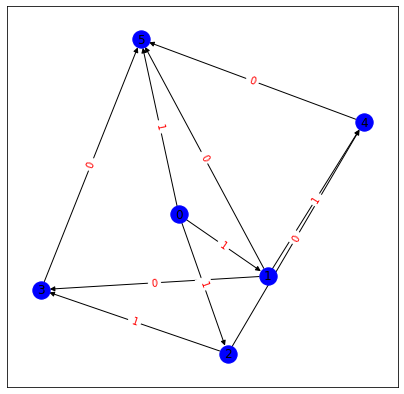

In [18]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(G, color, edge_labels):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G, seed=42), edge_labels=edge_labels, font_color='red')
    plt.show()


G = to_networkx(d_list[0], to_undirected=False)
edge_labels = dict([((edge[0], edge[1]), int(label))
                    for edge, label in zip(G.edges(data=False), d_list[0].edge_type)])
visualize_graph(G, color=data.y, edge_labels = edge_labels)